<a href="https://colab.research.google.com/github/Anjalichimnani/EVA4/blob/master/Assignment_12/EVA_S12_TinyImageNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%matplotlib inline
#https://modelzoo.co/model/data-augmentation-and-sampling-for-pytorch

In [3]:
# Mount the Google Drive to load the Libraries

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
# Import the required classes from the drive

import sys
sys.path.append('/content/drive/My Drive/EVA4/Assignment_12/files/')
from imports.imports_eva import *

from models.CustomNet import CustomNet
from models import ResNet18

from dataloaders import train_test_def as ttd
from dataloaders import albumentation_transform as albumentation_transform
from dataloaders.custom_data_loader import custom_data_loader

from optimizer.torch_lr_finder.lr_finder import LRFinder

from supplements.Supplements import Supplements

from dataloaders import train_test_def as ttd


  pip install torch-lr-finder -v --global-option="amp"


In [5]:
# Tiny IMagenet Download
! git clone https://github.com/seshuad/IMagenet
! ls 'IMagenet/tiny-imagenet-200/'

Cloning into 'IMagenet'...
remote: Enumerating objects: 120594, done.
remote: Total 120594 (delta 0), reused 0 (delta 0), pack-reused 120594
Receiving objects: 100% (120594/120594), 212.68 MiB | 24.39 MiB/s, done.
Resolving deltas: 100% (1115/1115), done.
Checking out files: 100% (120206/120206), done.
test  train  val  wnids.txt  words.txt


In [0]:
# Define Variables

train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
classes = []
classes_desc = {}
train_data = []
train_labels = []
test_data = []
test_labels = []

batch_size = 256
num_workers = 4
root_path = 'IMagenet/tiny-imagenet-200/'
class_file = 'wnids.txt'
class_desc_file = 'words.txt'
split_perc = 0.7                # Split Percentage for Train and Test Data set
train_folder = 'train'

In [0]:
# Obtain the classes, Class Description, Train_data and Validation_data via the library
# This is gneric code to get any train/validation data and shuffle them together
classes = Supplements.get_classes_from_file (root_path=root_path, filename=class_file)
classes_desc = Supplements.get_class_desc_from_file (root_path=root_path, filename=class_desc_file)

train_data, train_labels = Supplements.get_train_data_from_file (root_path=root_path, classes = classes)
val_data, val_labels = Supplements.get_val_data_from_file (root_path=root_path)

data = Supplements.concatenate(train_data, val_data)
data_labels = Supplements.concatenate(train_labels, val_labels)

train_data, train_labels, val_data, val_labels = Supplements.data_shuffle_and_split (data, data_labels, split_perc)

In [0]:
# Define the Data Transform ad Dataset
data_transform = custom_data_loader.get_def_data_transform()

tinyimagenet_dataset = custom_data_loader.custom_data_set_image_folder(root_path=root_path, folder=train_folder, transform=data_transform)

In [0]:
# Obtain the Train and Test data set from the tiny image net data set with a split percentage
train_set, val_set = Supplements.dataset_shuffle_and_split (dataset=tinyimagenet_dataset, split_perc=split_perc)

In [0]:
# Define Train and Test Data Loader from Train set/Test set split above
train_loader = custom_data_loader.data_loader(dataset=train_set, batch_size=batch_size, num_workers=num_workers, shuffle=True)
test_loader = custom_data_loader.data_loader(dataset=val_set, batch_size=batch_size, num_workers=num_workers, shuffle=False)

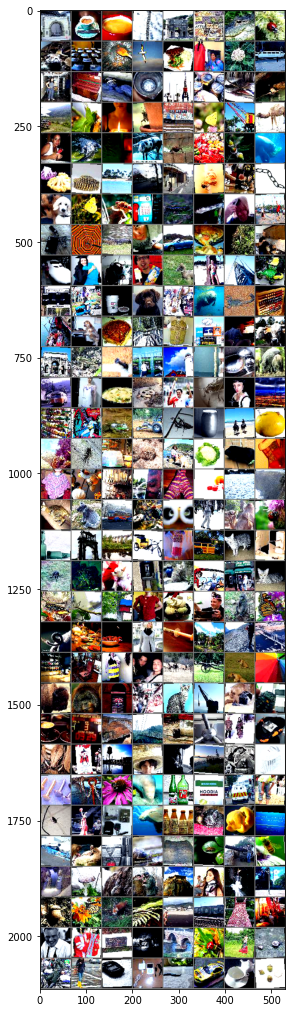

In [11]:
# Display Images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.figure(figsize=(28,18))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# get some random training images
dataiter = iter(train_loader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

In [12]:
# Check the Model Summary - Parameters used and memory consumed. 
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

model = ResNet18.get_model_instance().to(device)
summary(model, input_size=(3, 64, 64))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
            Conv2d-3           [-1, 64, 64, 64]          36,864
       BatchNorm2d-4           [-1, 64, 64, 64]             128
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
        BasicBlock-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
           Conv2d-10           [-1, 64, 64, 64]          36,864
      BatchNorm2d-11           [-1, 64, 64, 64]             128
       BasicBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13          [-1, 128, 32, 32]          73,728
      BatchNorm2d-14          [-1,

In [0]:
# Define Optimizer with L2 Regularization and Step LR Scheduler
optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=0.001)  
scheduler = StepLR(optimizer, step_size=15, gamma=0.1)

In [0]:
# Run the Model for 50 Epochs and obtian the Train/Text Accuracies
EPOCHS = 50
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    a,b = ttd.train(model, device, train_loader, optimizer, epoch)
    train_losses.extend(a)
    train_accuracy.extend(b)
    c,d = ttd.test(model, device, test_loader)
    test_losses.extend(c)
    test_accuracy.extend(d)
    scheduler.step()
    print('')

  0%|          | 0/274 [00:00<?, ?it/s]

EPOCH: 1


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0171, Accuracy: 2364/30000 (7.88%)


EPOCH: 2


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0153, Accuracy: 4378/30000 (14.59%)


EPOCH: 3


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0146, Accuracy: 5135/30000 (17.12%)


EPOCH: 4


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0136, Accuracy: 6583/30000 (21.94%)


EPOCH: 5


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0137, Accuracy: 6612/30000 (22.04%)


EPOCH: 6


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0121, Accuracy: 8332/30000 (27.77%)


EPOCH: 7


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0114, Accuracy: 9539/30000 (31.80%)


EPOCH: 8


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9231/30000 (30.77%)


EPOCH: 9


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0112, Accuracy: 9882/30000 (32.94%)


EPOCH: 10


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0109, Accuracy: 10465/30000 (34.88%)


EPOCH: 11


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0127, Accuracy: 8208/30000 (27.36%)


EPOCH: 12


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 10028/30000 (33.43%)


EPOCH: 13


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0113, Accuracy: 9962/30000 (33.21%)


EPOCH: 14


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0107, Accuracy: 10800/30000 (36.00%)


EPOCH: 15


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0120, Accuracy: 9582/30000 (31.94%)


EPOCH: 16


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 16029/30000 (53.43%)


EPOCH: 17


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0074, Accuracy: 16145/30000 (53.82%)


EPOCH: 18


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0075, Accuracy: 15989/30000 (53.30%)


EPOCH: 19


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0076, Accuracy: 15916/30000 (53.05%)


EPOCH: 20


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0077, Accuracy: 15741/30000 (52.47%)


EPOCH: 21


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0079, Accuracy: 15556/30000 (51.85%)


EPOCH: 22


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 15402/30000 (51.34%)


EPOCH: 23


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0081, Accuracy: 15407/30000 (51.36%)


EPOCH: 24


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 15185/30000 (50.62%)


EPOCH: 25


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 15306/30000 (51.02%)


EPOCH: 26


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 15285/30000 (50.95%)


EPOCH: 27


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 15405/30000 (51.35%)


EPOCH: 28


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 15272/30000 (50.91%)


EPOCH: 29


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0083, Accuracy: 15080/30000 (50.27%)


EPOCH: 30


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0082, Accuracy: 15337/30000 (51.12%)


EPOCH: 31


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15691/30000 (52.30%)


EPOCH: 32


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15699/30000 (52.33%)


EPOCH: 33


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15691/30000 (52.30%)


EPOCH: 34


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15700/30000 (52.33%)


EPOCH: 35


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15723/30000 (52.41%)


EPOCH: 36


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15705/30000 (52.35%)


EPOCH: 37


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15735/30000 (52.45%)


EPOCH: 38


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15779/30000 (52.60%)


EPOCH: 39


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15775/30000 (52.58%)


EPOCH: 40


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15741/30000 (52.47%)


EPOCH: 41


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15711/30000 (52.37%)


EPOCH: 42


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15699/30000 (52.33%)


EPOCH: 43


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15677/30000 (52.26%)


EPOCH: 44


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15619/30000 (52.06%)


EPOCH: 45


  0%|          | 0/274 [00:00<?, ?it/s]


Test set: Average loss: 0.0080, Accuracy: 15694/30000 (52.31%)


EPOCH: 46


Loss=0.029 Batch_id=72 Accuracy=99.98:  27%|██▋       | 73/274 [02:18<06:13,  1.86s/it]